In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]


# Step 1

In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(614, 1, 4)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)

date_test=date[438:623,:]

# Step 2

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [6]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# Step 3

In [7]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.03833334892988205
Epoch: 10/100............. Loss: 0.004440684337168932
Epoch: 20/100............. Loss: 0.0012322691036388278
Epoch: 30/100............. Loss: 0.0004480796051211655
Epoch: 40/100............. Loss: 0.00015366138541139662
Epoch: 50/100............. Loss: 0.0001001931304926984
Epoch: 60/100............. Loss: 9.925949416356161e-05
Epoch: 70/100............. Loss: 9.503358887741342e-05
Epoch: 80/100............. Loss: 9.187682735500857e-05
Epoch: 90/100............. Loss: 9.098619193537161e-05


In [8]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

In [9]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.043032,0.037434,1.966979,6.663611
2 day,0.039619,0.035004,2.025037,7.187002
3 day,0.045816,0.039659,1.794406,5.524446
4 day,0.051911,0.043396,1.506151,3.451377


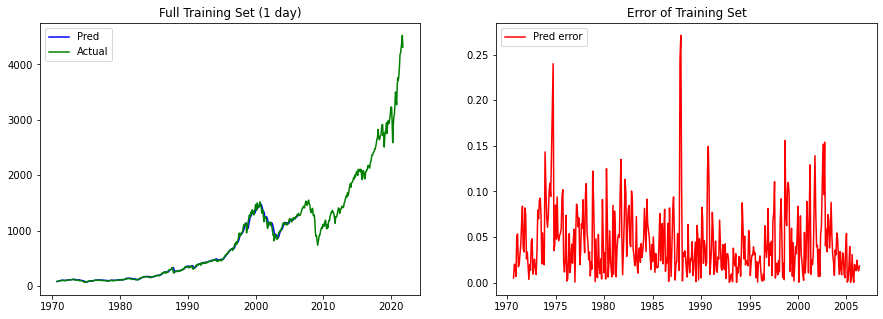

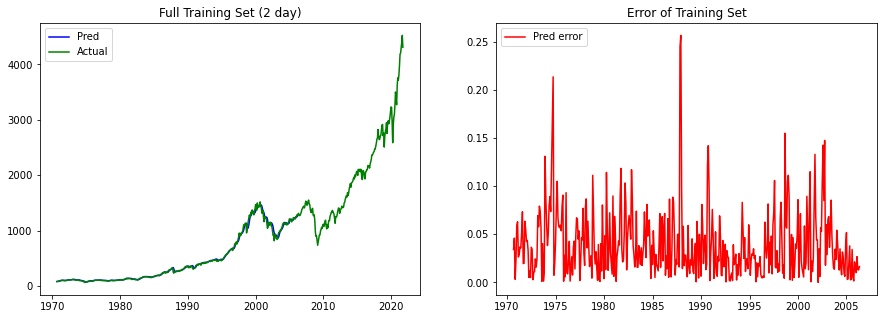

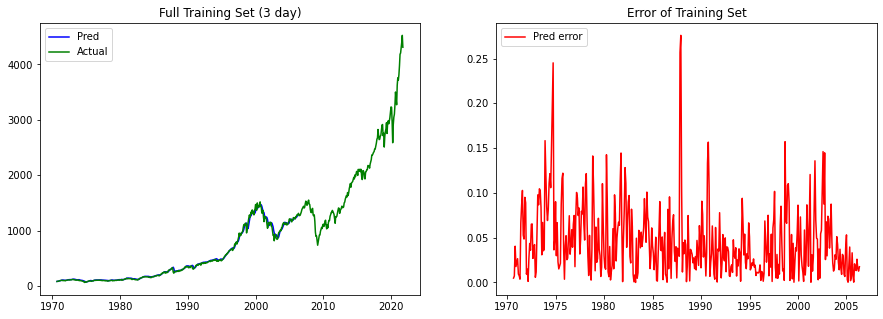

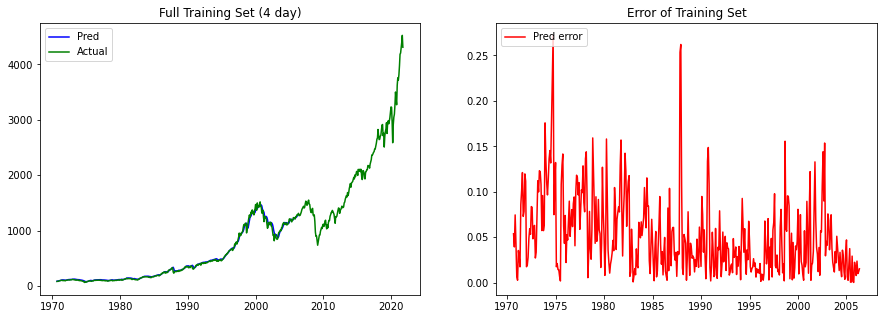

In [10]:
table = []

error = prediction_error(output_plt1, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (1 day)")
ax1.plot(date_ft, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (2 day)")
ax1.plot(date_ft, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (3 day)")
ax1.plot(date_ft, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (4 day)")
ax1.plot(date_ft, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 4 

In [11]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.084212,0.070637,1.480482,1.827990
2 day,0.081105,0.067467,1.410126,1.578121
3 day,0.086811,0.073206,1.452733,1.730612
4 day,0.084488,0.074064,1.523500,2.012841


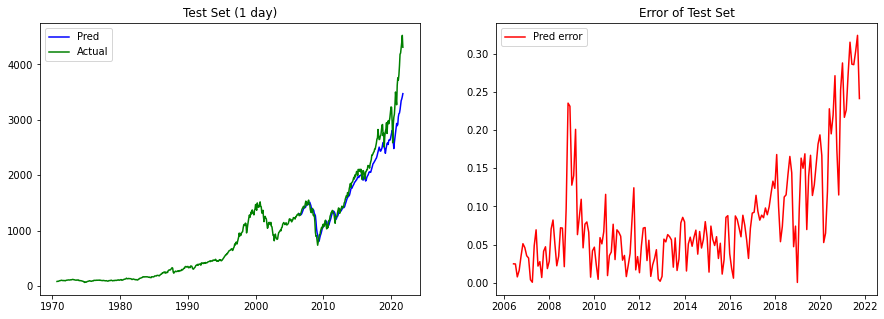

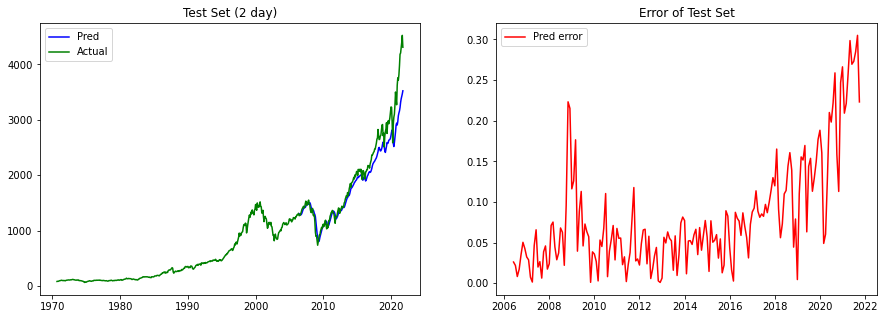

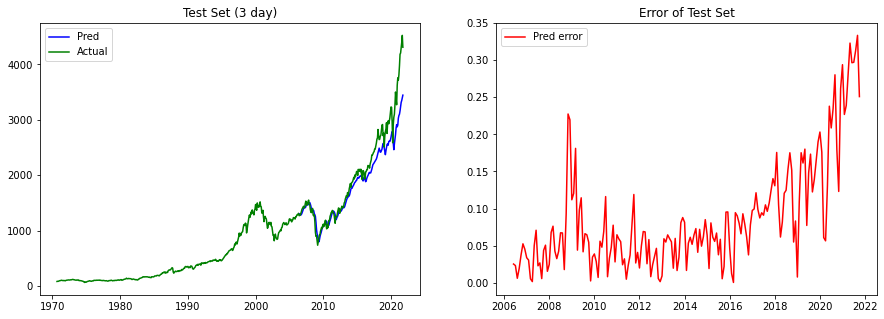

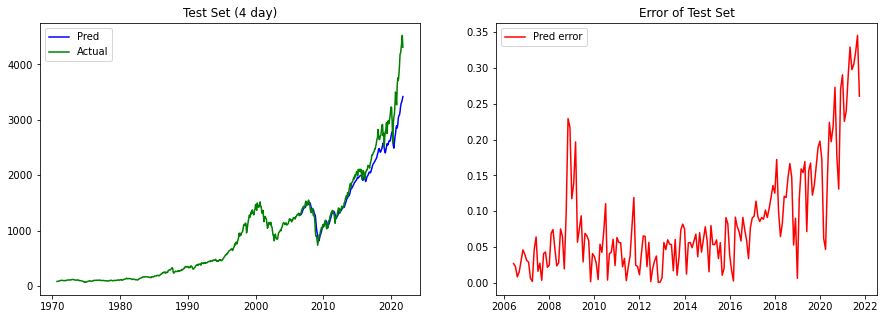

In [12]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)
                  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 5

In [13]:
RNNval = Model(input_size=2, output_size=4, hidden_dim=32, n_layers=2)
optimizerVal = torch.optim.Adam(RNNval.parameters(), lr=0.002)
criterionVal = nn.MSELoss()
RNNval

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(200):
    optimizerVal.zero_grad()
    
    output, hidden = RNNval(xTensor)
    loss = criterionVal(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizerVal.step()
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 200), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.02839912474155426
Epoch: 100/200............. Loss: 0.00015910428192000836


In [14]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_trainingplt = norm.inverse_transform(Y_training[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.049704,0.042081,1.659582,4.413153
2 day,0.054456,0.045460,1.620493,4.304552
3 day,0.057049,0.046906,1.597651,4.284149
4 day,0.055814,0.044836,1.690619,4.896780


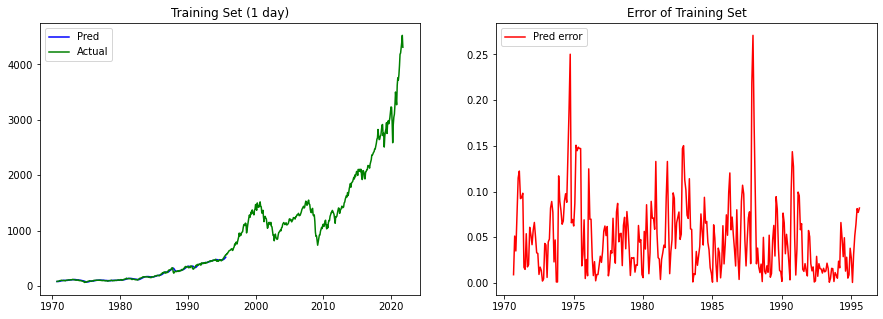

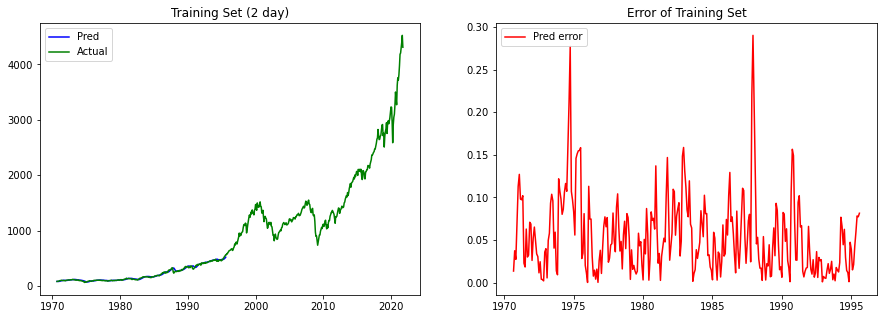

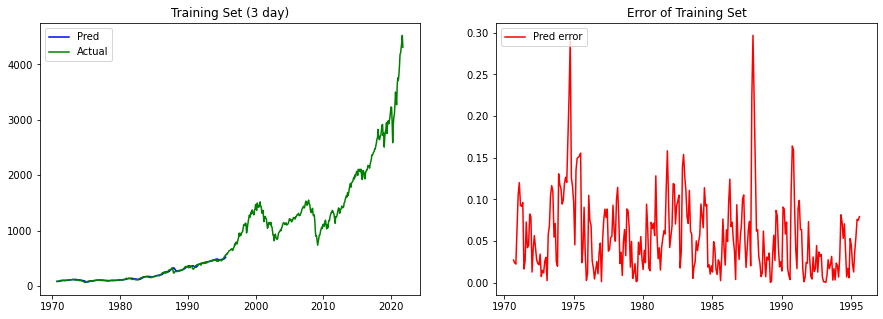

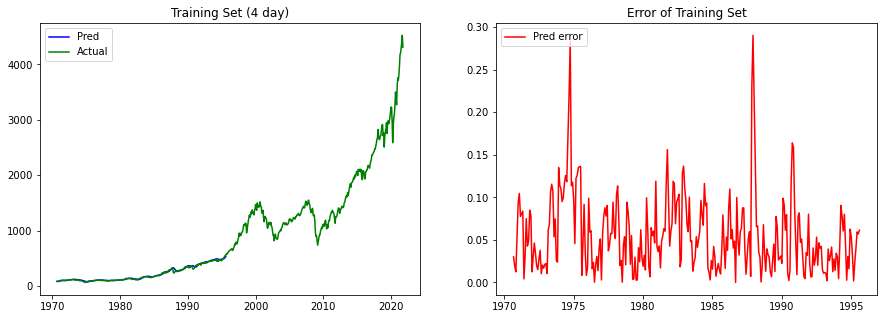

In [15]:
table = []

error = prediction_error(output_plt1, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (1 day)")
ax1.plot(date_tr, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (2 day)")
ax1.plot(date_tr, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (3 day)")
ax1.plot(date_tr, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (4 day)")
ax1.plot(date_tr, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [16]:
RNNval.eval()
xTensor = torch.from_numpy(X_validation).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_validationplt = norm.inverse_transform(Y_validation[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.103113,0.052853,0.174528,-0.275884
2 day,0.103215,0.054045,0.342576,-0.357833
3 day,0.101927,0.054490,0.371487,-0.381169
4 day,0.082874,0.047312,0.527652,-0.172485


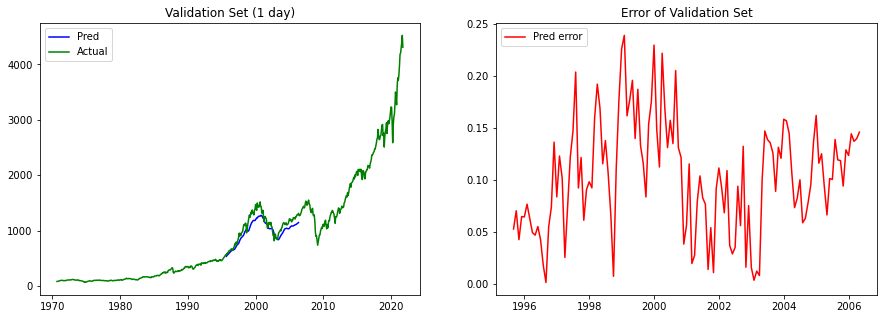

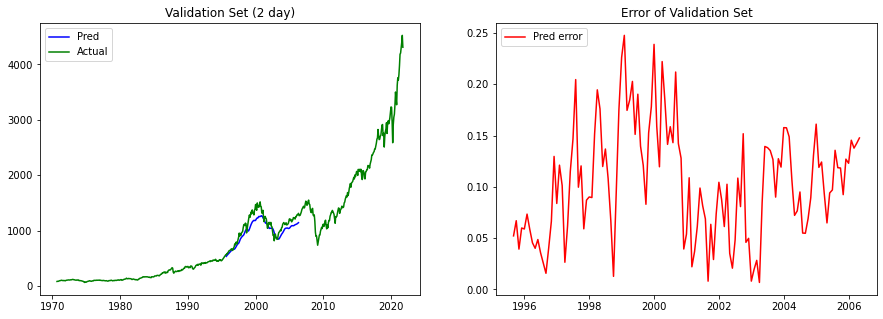

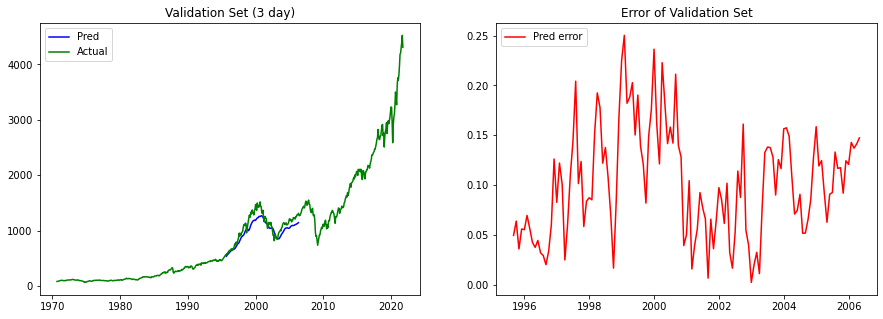

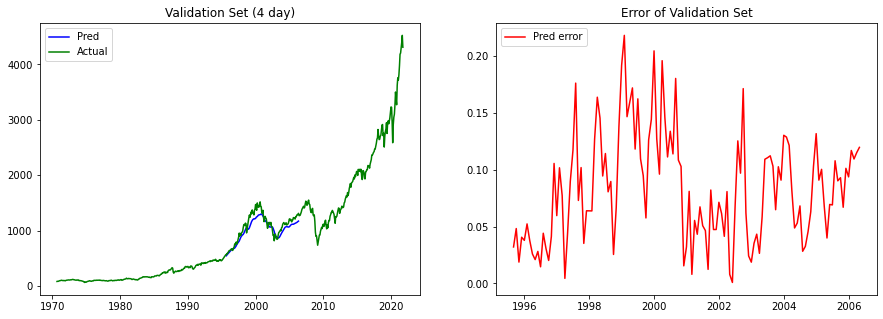

In [17]:
table = []

error = prediction_error(output_plt1, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (1 day)")
ax1.plot(date_v, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (2 day)")
ax1.plot(date_v, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (3 day)")
ax1.plot(date_v, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (4 day)")
ax1.plot(date_v, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [18]:
xTensor = torch.from_numpy(X_test).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.290507,0.191107,1.103380,0.844610
2 day,0.338375,0.247059,1.216235,1.099146
3 day,0.348621,0.263510,1.288691,1.343697
4 day,0.298787,0.227015,1.202614,1.044323


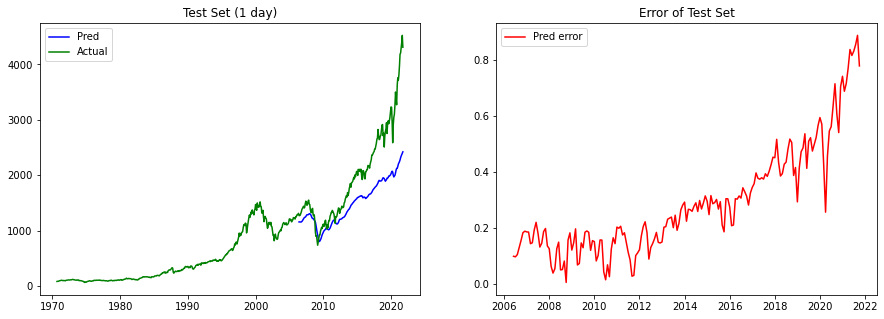

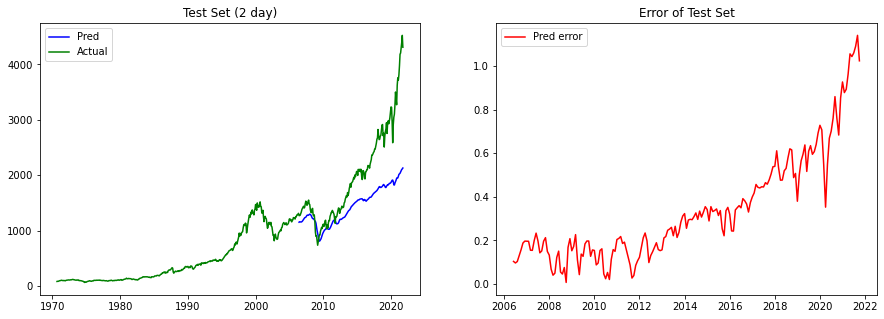

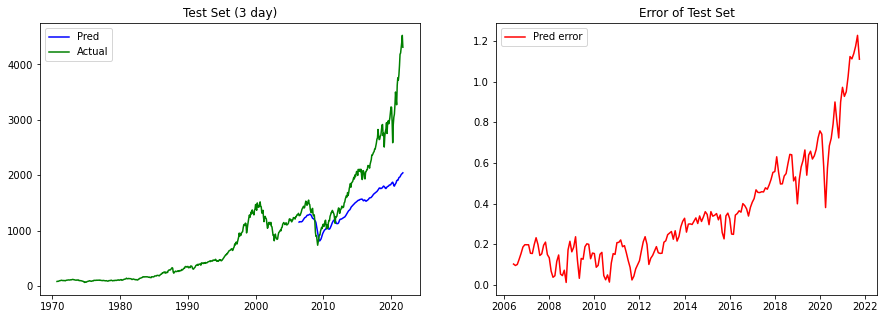

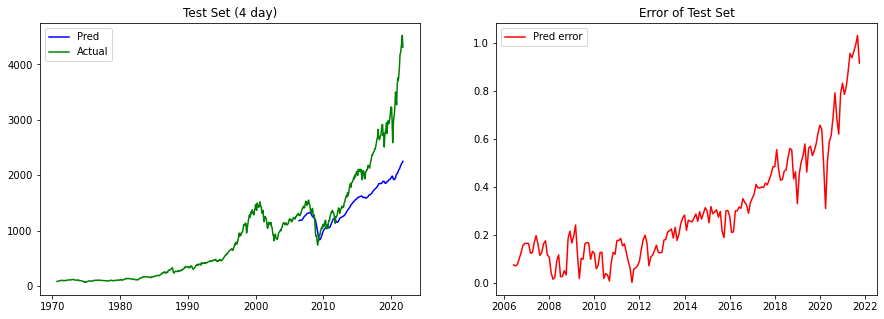

In [19]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 6

In [20]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(180)), 18)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


In [21]:
#predict next day (day_index = 0)
day_index = 0
out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
target = norm.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stdev:
    noisy_data = NoisyTesting(X_test, sigma)
    inputs = Variable(torch.from_numpy(noisy_data).float())
    output, _ = RNNval(inputs)
    out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                               output.detach().numpy()[:, [day_index]],  
                               output.detach().numpy()[:, [day_index]]), axis=1)
    predicted_price = norm.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target, predicted_price)
    error_res_all.append(error.reshape(-1))


In [22]:
labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
df_error

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.090561,0.090577,0.090593,0.090386,0.090848,0.090643,0.088981,0.089996,0.099953,0.090616
01/09/2006,0.089052,0.089052,0.089052,0.089052,0.089052,0.089052,0.089052,0.089052,0.089052,0.089052
01/10/2006,0.095399,0.095399,0.095399,0.095399,0.095399,0.095399,0.095399,0.095399,0.095399,0.095399
01/11/2006,0.115307,0.115953,0.115631,0.115358,0.116330,0.115912,0.108240,0.108738,0.119325,0.054926
01/12/2006,0.135157,0.135157,0.135157,0.135157,0.135157,0.135157,0.135157,0.135157,0.135157,0.135157
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.587902,0.534621,0.985087,0.577404,0.810119,0.541377,0.896836,0.680564,0.960649,0.601647
01/09/2021,1.733920,0.522473,0.985411,0.758321,1.228733,0.630421,0.985249,0.667716,0.939223,0.570946
01/10/2021,0.558767,0.545188,0.985736,0.738998,0.985796,0.686499,0.935527,0.678306,0.963655,0.724594
01/11/2021,1.651590,0.513786,0.337136,0.652688,0.986138,0.703050,1.386740,0.682174,0.985515,0.727980


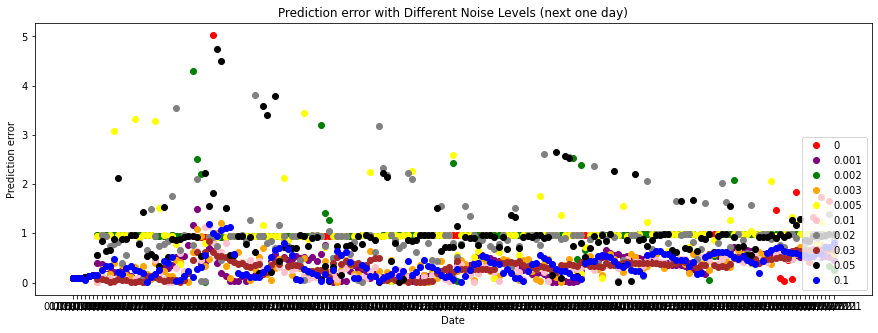

In [23]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(stdev)): 
    #print(np.shape(date_test))
    #print(np.shape(error_res_all[i]))
    #print(np.shape(cmaps[i]))
    plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  

plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels (next one day)')
plt.legend(loc="lower right") 

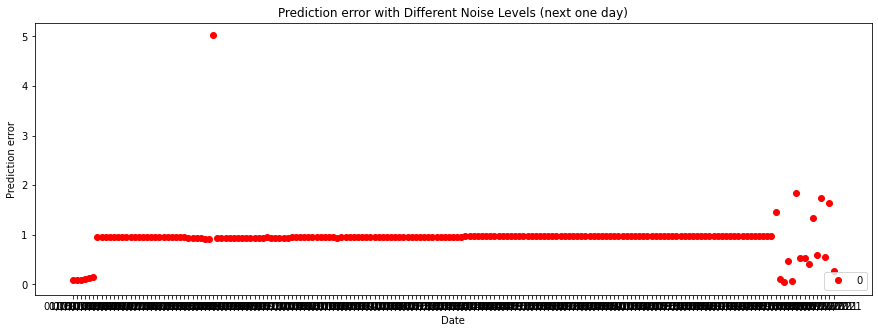

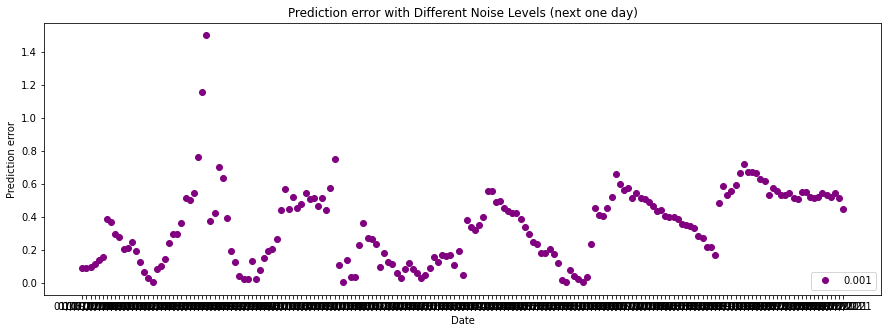

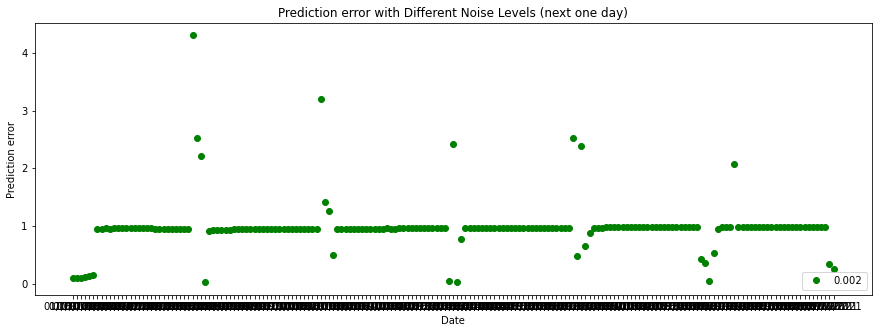

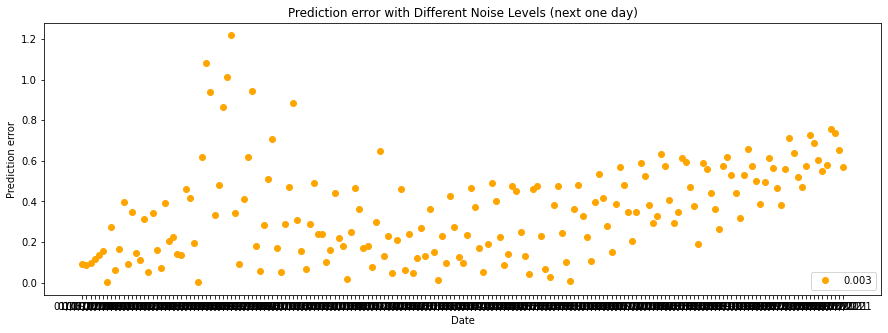

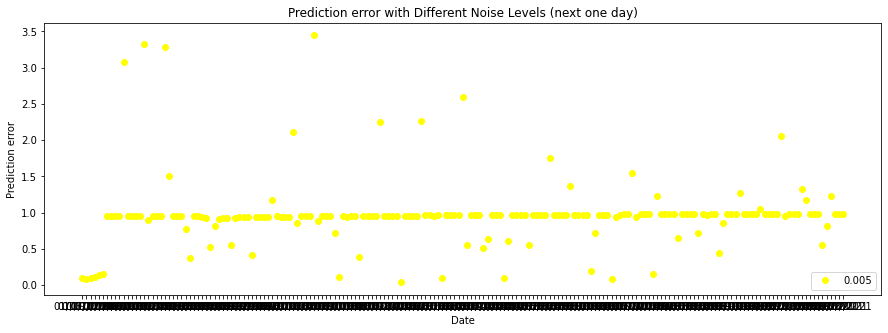

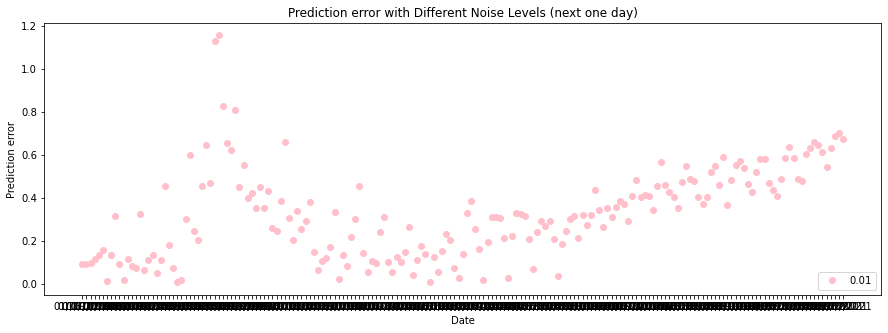

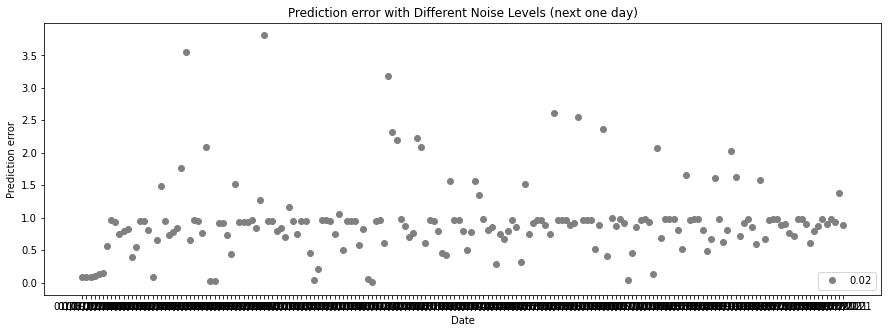

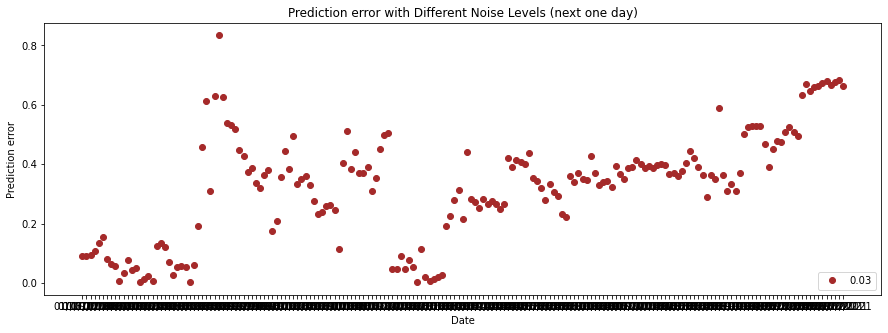

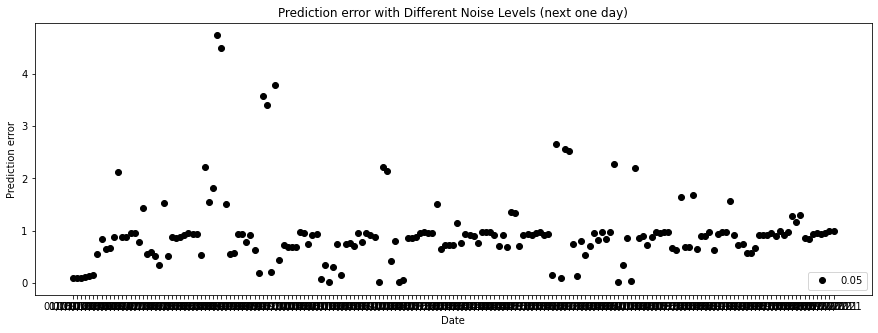

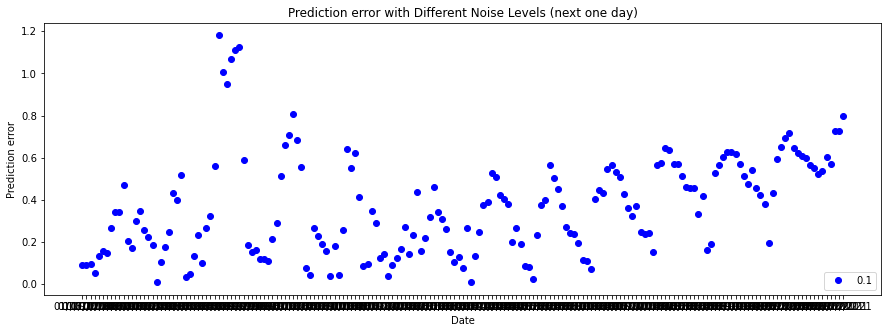

In [24]:
for i in range(len(stdev)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()